# Weather Mapping - Weather Visualization

### Dependencies and data

In [44]:
# Dependencies
import os
import gmaps
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.stats import linregress
from config import GMAPS_KEY
%matplotlib inline

In [45]:
# Plot styles
print(mpl.style.available)

['Solarize_Light2', '_classic_test_patch', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn', 'seaborn-bright', 'seaborn-colorblind', 'seaborn-dark', 'seaborn-dark-palette', 'seaborn-darkgrid', 'seaborn-deep', 'seaborn-muted', 'seaborn-notebook', 'seaborn-paper', 'seaborn-pastel', 'seaborn-poster', 'seaborn-talk', 'seaborn-ticks', 'seaborn-white', 'seaborn-whitegrid', 'tableau-colorblind10']


In [55]:
# Plot settings
mpl.style.use('seaborn')
mpl.rcParams['font.size'] = 15

# Configure API key
gmaps.configure(api_key=GMAPS_KEY)

In [47]:
# Weather data
weather_df = pd.read_csv('data/weather.csv')
weather_df.head(2)

,Id,City,Country,Latitude,Longitude,Time,Description,Max Temp,Humidity,Wind Speed,Cloudiness,Rain,Snow
0,0,Garoowe,SO,8.4054,48.4845,2021-04-18 15:28:30,clear sky,89.92,30,16.42,6,0,0
1,1,Vendas Novas,PT,38.6771,-8.4579,2021-04-18 15:28:30,few clouds,73.40,46,12.66,20,0,0


In [48]:
# Split data into northern and southern hemispheres
north_df = weather_df.query('Latitude >= 0').copy()
south_df = weather_df.query('Latitude < 0').copy()
north_df.shape[0], south_df.shape[0]

(705, 318)

### How does weather change with changing latitudes?

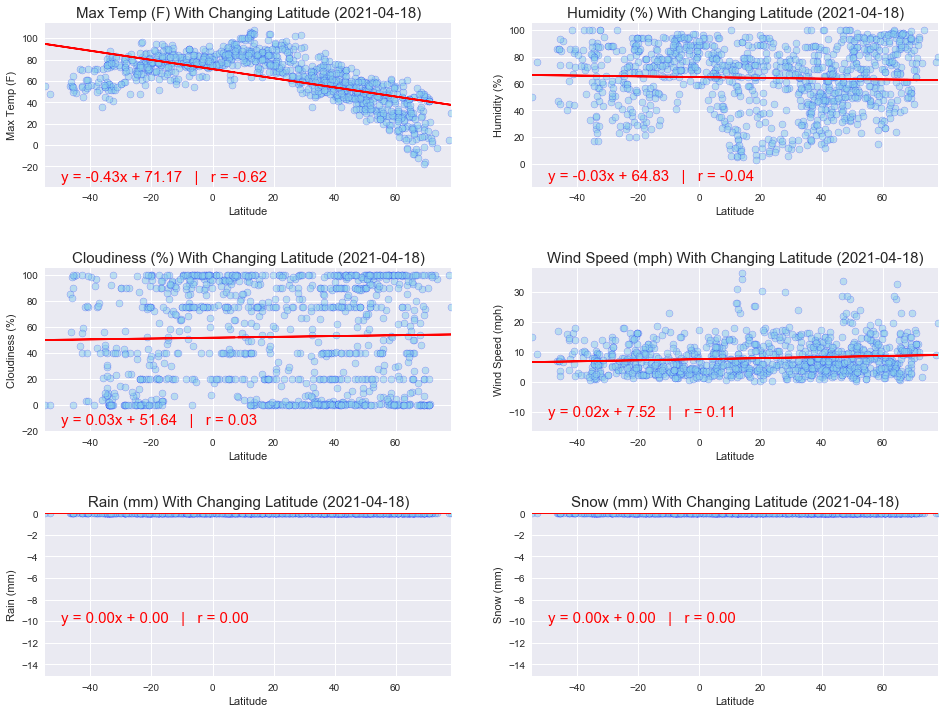

In [56]:
# Weather date
w_date = weather_df.loc[0, 'Time'][:10]


def weather_linreg(data, y, x='Latitude', ax=plt, txt_loc=None, date=w_date, x_suffix=''):
    
    """
    Plot a weather variable against the latitude, with a regression line.
    
    Parameters
    ----------
    data : pandas.core.frame.DataFrame
        Weather data
    y : str
        Name of weather variable to plot
    x : str, optional
        Name of latitude variable, by default "Latitude"
    ax : matplotlib.axes._subplots.AxesSubplot, optional
        Axis to plot on, by default the {matplotlib.pyplot} module
    txt_loc : tuple(int, int), optional
        Coordinates for text annotation, by default None
    date : str, optional
        Date of the weather data, by default {w_date}
    x_suffix : str, optional
        Suffix to add to x-label, by default ""
        
    Returns
    -------
    m, b, r, p : float (all)
        Slope, y-intercept, Pearson correlation coefficient, and p-value from linear regression
    """
    
    # Linear regression
    m, b, r, p, _ = linregress(data[x], data[y]) # slope, y-int, corr coef, p-val, stderr
    line = m * data[x] + b # regression line
    eq = f'y = {m:.2f}x + {b:.2f}   |   r = {r:.2f}' # regression equation and corr coef
    
    # Plot points and line
    ax.scatter(data[x], data[y], c='skyblue', edgecolor='blue', alpha=0.5)
    ax.plot(data[x], line, c='red')
    
    # Annotate equation and correlation coef
    try: # only works if `ax` is an axis, not the `pyplot` module
        if txt_loc is None:
            ax.set_xlim(data[x].min(), data[x].max())
            ax.set_ylim(ax.get_ylim()[0] - 15, ax.get_ylim()[1]) # create room at the bottom for annotation
            txt_loc = (ax.get_xlim()[0] + 5, ax.get_ylim()[0] + 5) # annotate at bottom left
        ax.annotate(eq, txt_loc, c='red')
    except:
        print('No annotation')
    
    # Add units to y-label
    if y == 'Max Temp':
        y += ' (F)' # degrees Fahrenheit
    elif y == 'Wind Speed':
        y += ' (mph)' # miles per hour
    elif y in ['Rain', 'Snow']:
        y += ' (mm)' # millimeters of rain or snow
    else:
        y += ' (%)' # percent humidity or cloudiness
    
    # Labels
    ax.set_title(f'{y} With Changing {x} ({date})', fontsize=15)
    ax.set_ylabel(y)
    ax.set_xlabel(x + x_suffix)
    
    return m, b, r, p # slope, y-int, corr, p-val
    
    
# Figure and axes
weather_vars, j = ['Max Temp', 'Humidity', 'Cloudiness', 'Wind Speed', 'Rain', 'Snow'], 0
n_vars = len(weather_vars) # num of weather vars
fig, ax = plt.subplots(n_vars // 2, 2, figsize=(12, n_vars * 2)) # create 2 cols of subplots
fig.subplots_adjust(hspace=0.5) # add horizontal spacing

# Weather subplots
for i in range(n_vars // 2):
    weather_linreg(weather_df, weather_vars[j], ax=ax[i][0])
    weather_linreg(weather_df, weather_vars[j+1], ax=ax[i][1])
    j += 2

### Weather in southern vs. northern hemisphere

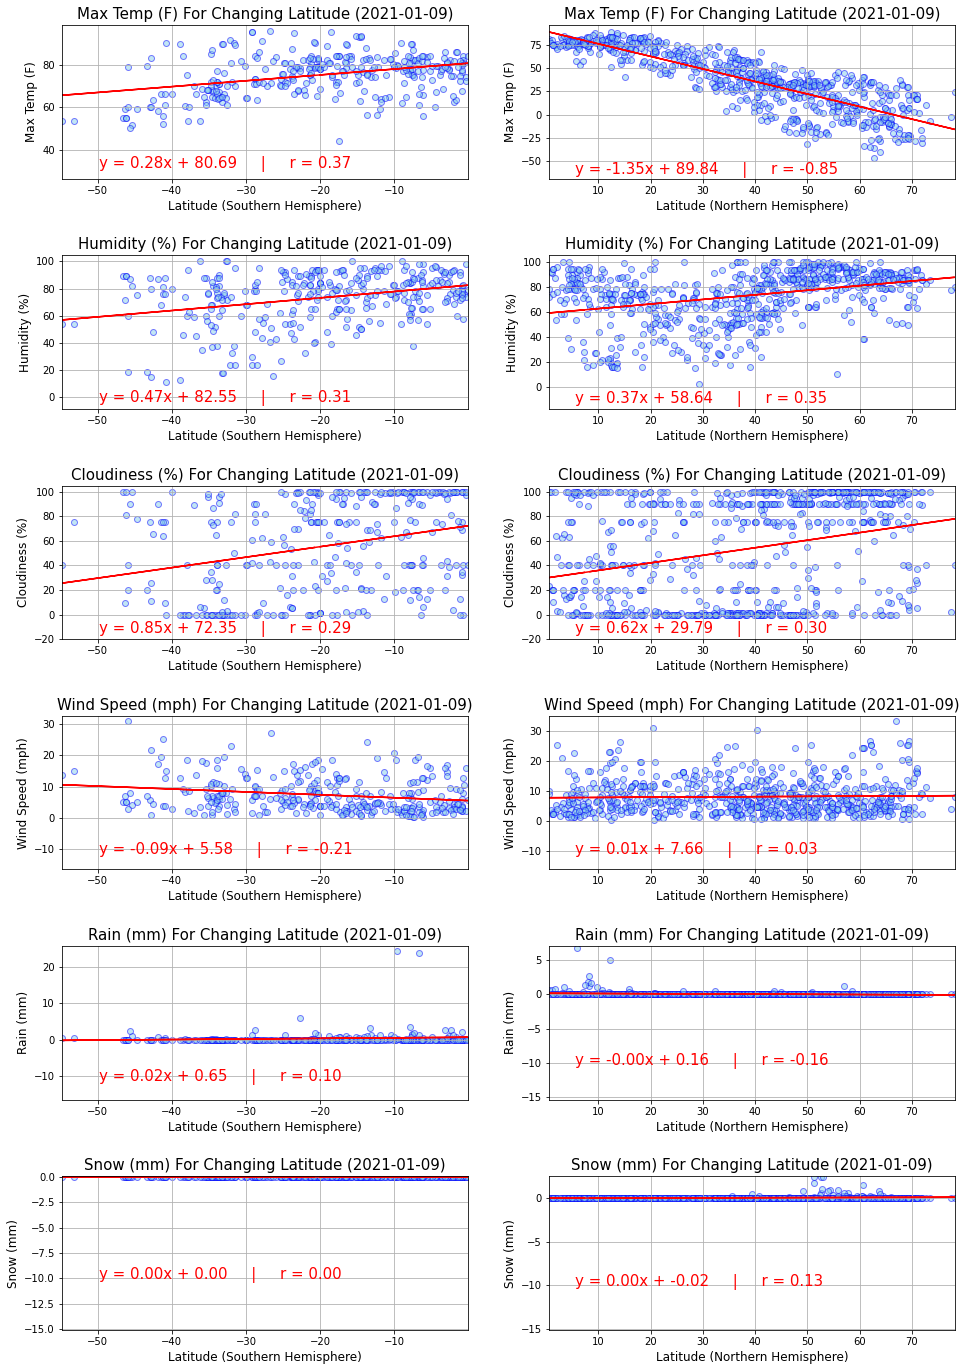

In [18]:
# Figure and axes
fig, ax = plt.subplots(n_cols, 2, figsize=(16, n_cols * 4))
fig.subplots_adjust(hspace=0.5) # add horizontal spacing

# Weather subplots
for i in range(n_cols):
    weather_linreg(weather_feats[i], data=south_weather, ax=ax[i][0], x_suffix=' (Southern Hemisphere)')
    weather_linreg(weather_feats[i], data=north_weather, ax=ax[i][1], x_suffix=' (Northern Hemisphere)')

### Weather Heatmaps

In [19]:
# For Jupyterlab
# !jupyter labextension install @jupyter-widgets/jupyterlab-manager
# !jupyter lab build

In [26]:
def weather_heatmap(data, measurement, center=(30.0, 31.0), zoom_level=1.5, point_radius=3, max_intensity=300):
    
    """
    Plot a heatmap of a specified weather measurement using the Google Maps API.
    
    Args:
        [1] data (Pandas dataframe) - weather data
        [2] measurement (str) - name of weather measurement
        [3] center (tuple(float, float)) - coordinates for map center
        [4] zoom_level (float) - map zoom
        [5] point_radius - heat radius
        [6] max_intensity - max value for heat scale
        
    Returns:
        [Google Maps figure] weather heatmap
    """
    
    # Locations and measurements
    locations = data[['Latitude', 'Longitude']]
    weights = data[measurement].apply(lambda t: max(t, 0)) # replace negative vals with 0

    # Heatmap
    heatmap_layer = gmaps.heatmap_layer(locations, weights, dissipating=False,
                                        point_radius=point_radius, max_intensity=max_intensity)
    fig = gmaps.figure(center=center, zoom_level=zoom_level)
    fig.add_layer(heatmap_layer)
    print(measurement)
    return fig


# Max temp heatmap
weather_heatmap(weather, weather_feats[0])

Max Temp


Figure(layout=FigureLayout(height='420px'))

In [27]:
# Humidity heatmap
weather_heatmap(weather, weather_feats[1])

Humidity


Figure(layout=FigureLayout(height='420px'))

In [39]:
# Cloudiness heatmap
weather_heatmap(weather, weather_feats[2])

Cloudiness


Figure(layout=FigureLayout(height='420px'))

In [41]:
# Wind speed heatmap
weather_heatmap(weather, weather_feats[3], max_intensity=100)

Wind Speed


Figure(layout=FigureLayout(height='420px'))

In [42]:
# Rain heatmap
weather_heatmap(weather, weather_feats[4], max_intensity=10)

Rain


Figure(layout=FigureLayout(height='420px'))

In [43]:
# Snow heatmap
weather_heatmap(weather, weather_feats[5], max_intensity=10)

Snow


Figure(layout=FigureLayout(height='420px'))